In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
import torch
from torch import nn
from dsin.ae.data_manager.data_loader import (
    SideinformationImageImageList, ImageSiTuple)
from dsin.ae import config
from dsin.ae.si_ae import SideInformationAutoEncoder
from dsin.ae.si_net import SiNetChannelIn
from dsin.ae.loss_man import LossManager
from dsin.ae.distortions import Distortions, DistTypes
from dsin.ae.kitti_normalizer import ChangeImageStatsToKitti, ChangeState
from dsin.ae import config


In [3]:
config.H_target = 2* 0.3
config.autoencoder_loss_distortion_to_minimize=DistTypes.MS_SSMIM
config.beta

500

In [4]:
class AverageMetric(Callback):
    "Wrap a `func` in a callback for metrics computation."
    def __init__(self, func):
        # If it's a partial, use func.func
        name = getattr(func,'func',func).__name__
        self.func, self.name = func, name

    def on_epoch_begin(self, **kwargs):
        "Set the inner value to 0."
        self.val, self.count = 0.,0

    def on_batch_end(self, last_output, last_target, **kwargs):
        "Update metric computation with `last_output` and `last_target`."
        if not is_listy(last_target): last_target=[last_target]
        self.count += last_target[0].size(0) # batch size
        X_DEC_IND =1
        val = self.func(last_output[X_DEC_IND], last_target[0])
        self.val += last_target[0].size(0) * val.detach().cpu()

    def on_epoch_end(self, last_metrics, **kwargs):
        "Set the final result in `last_metrics`."
        return add_metrics(last_metrics, self.val/self.count)

In [5]:
config.use_si_flag = SiNetChannelIn.WithSideInformation
config.use_si_flag

<SiNetChannelIn.WithSideInformation: 6>

In [6]:
torch.__version__

'1.4.0'

In [7]:
si_autoencoder = SideInformationAutoEncoder(config.use_si_flag)
path = "../src/dsin/data"
pct= 0.5
valid_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_general_val.txt"])
train_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_general_train.txt"],pct=pct)

image_lists = ItemLists(
    path=path, train=train_image_list, valid=valid_image_list)

# ll = image_lists.label_from_func(lambda x: x)

tfms = None #get_transforms(do_flip=True, max_rotate=0.0)
batchsize = 1
data = (image_lists
        .label_from_func(lambda x: x)
        .transform(tfms, size=(336, 1224), resize_method=ResizeMethod.CROP, tfm_y=True)
        .databunch(bs=batchsize))
learn = Learner(data=data,
                     model=si_autoencoder,
                     opt_func=torch.optim.Adam,
                     loss_func=LossManager(config.use_si_flag),
                     metrics=[AverageMetric(Distortions._calc_dist)])



In [8]:
learn.model.true_tuple_loss_false_just_out = True
learn.model.use_side_infomation = SiNetChannelIn.NoSideInformation
learn.loss_func.use_side_infomation = SiNetChannelIn.NoSideInformation
learn.fit(1, lr=0.0005)
learn.save('general-ae-for-si')

epoch,train_loss,valid_loss,_calc_dist,time
0,239.765518,241.974503,4122.877930,7:18:04


In [9]:
learn.load('general-ae-for-si')
learn.model.true_tuple_loss_false_just_out = True
learn.model.use_side_infomation = SiNetChannelIn.WithSideInformation #SiNetChannelIn.NoSideInformation
learn.loss_func.use_side_infomation = SiNetChannelIn.WithSideInformation # SiNetChannelIn.NoSideInformation
learn.fit(1, lr=0.0005)
learn.save('withsi-general-ae-for-si')

epoch,train_loss,valid_loss,_calc_dist,time


KeyboardInterrupt: 

In [10]:
learn.save('withsi-general-ae-for-si')

In [10]:
learn.save('general-dsin-mssim -lr0p0005 -stereo-stage-1')

> /home/jupyter/tDSIN/src/dsin/ae/data_manager/data_loader.py(103)show_xyzs()
-> figsize = ifnone(figsize, (12, 3*len(xs)))
(Pdb) c


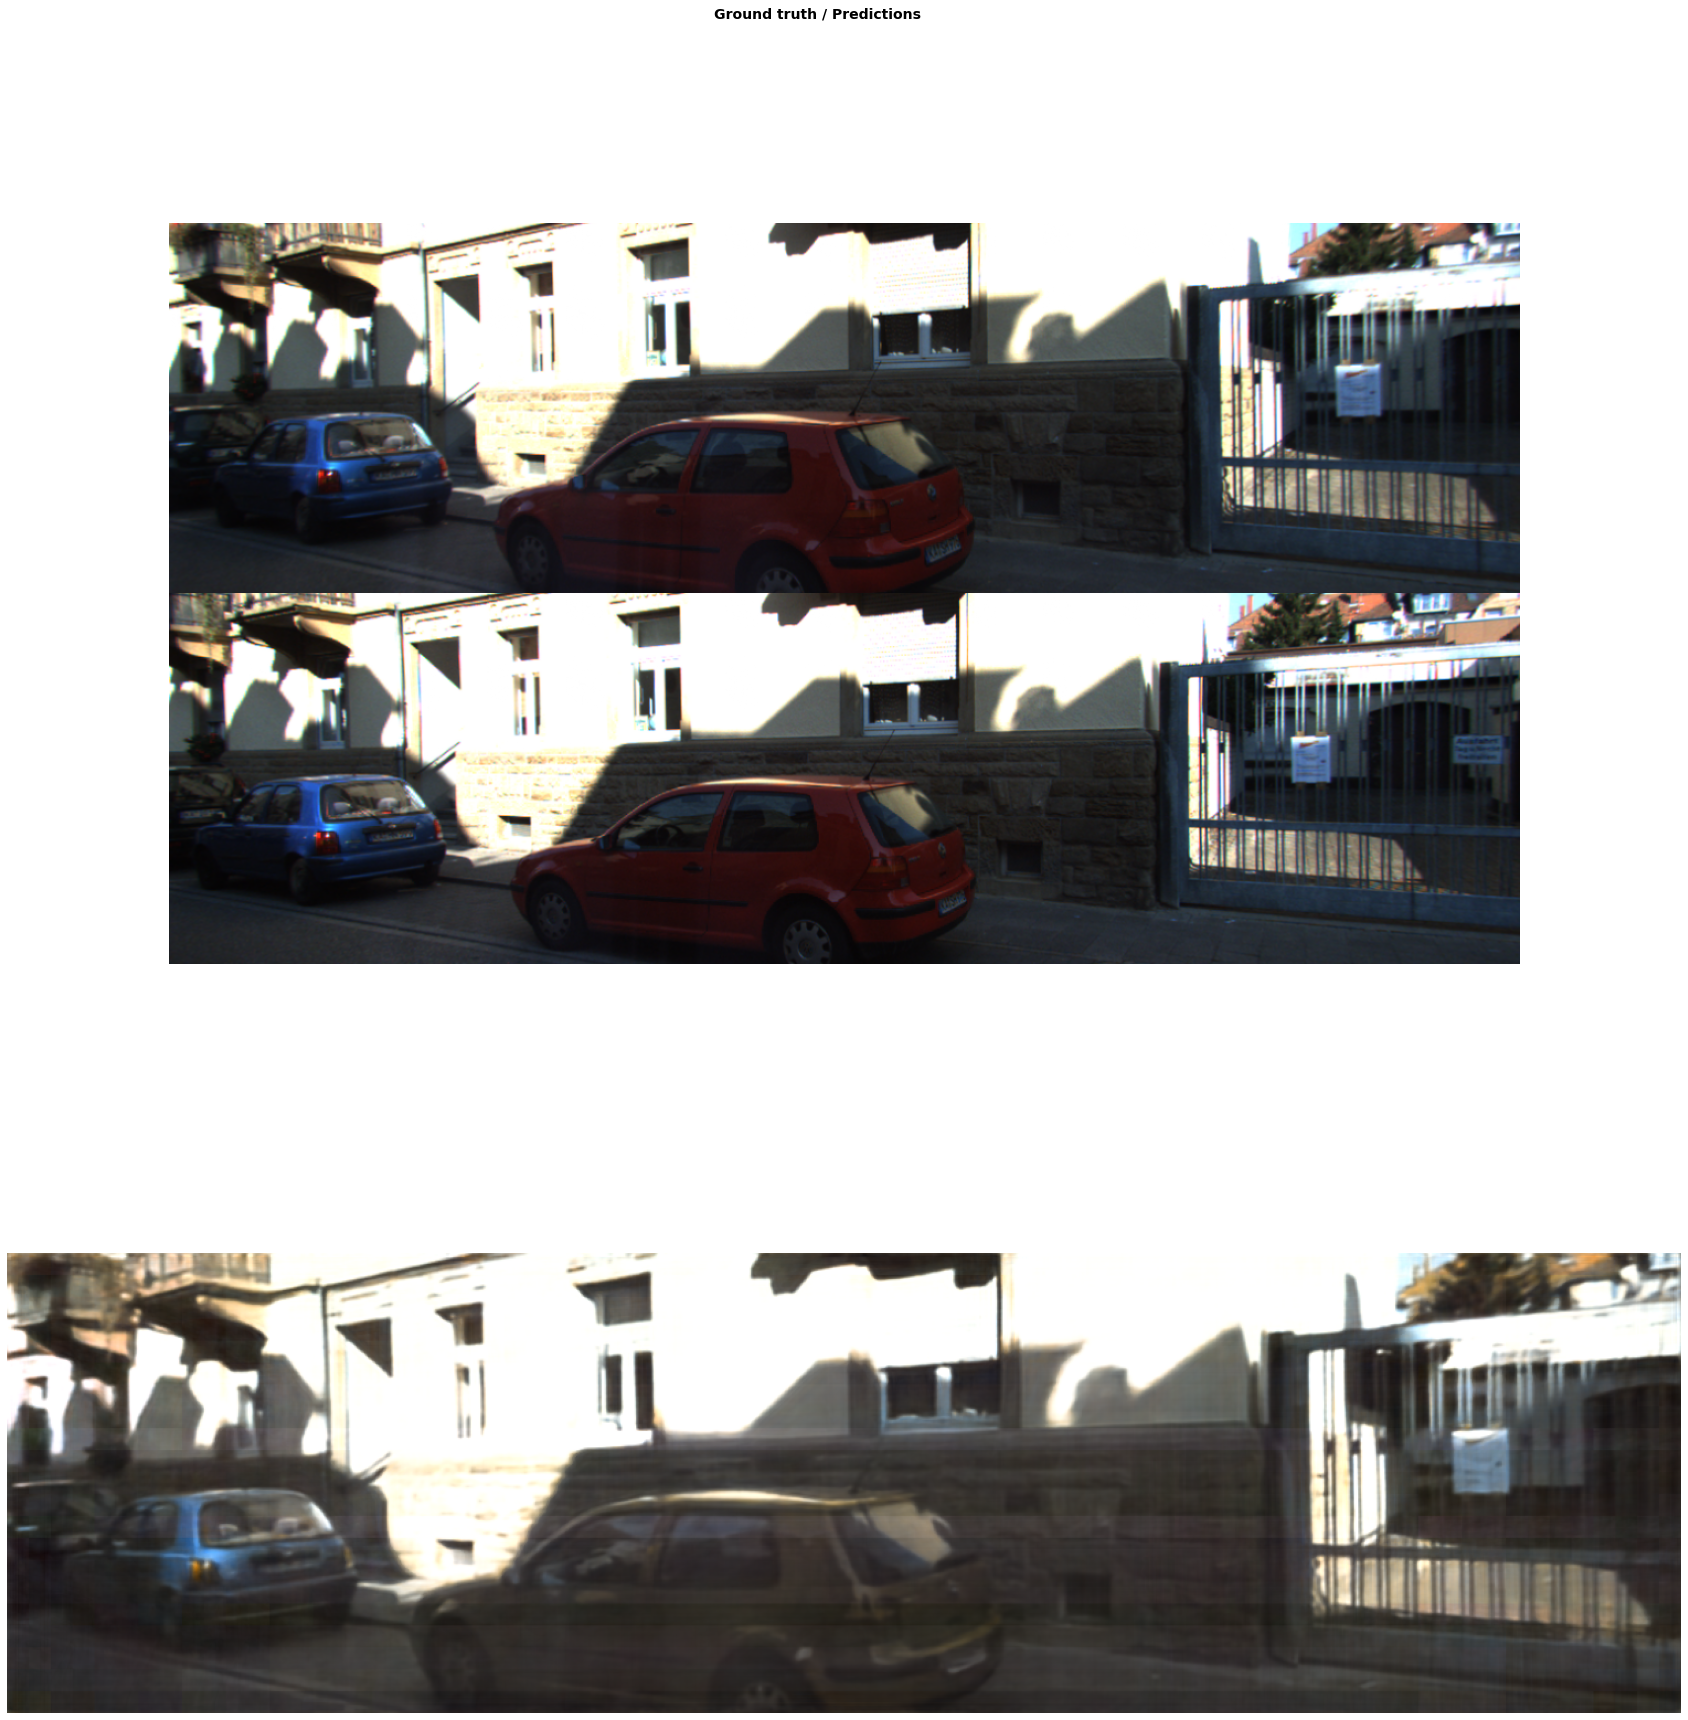

In [11]:
learn.model.true_tuple_loss_false_just_out = False

learn.show_results(figsize=(30,30))

In [17]:
learn.data.valid_ds[0]

(ImageSiTuple [tensor([[[0.7992, 0.8228, 0.8307,  ..., 0.9096, 0.7533, 0.5912],
          [0.7581, 0.7768, 0.7915,  ..., 0.9064, 0.7129, 0.5570],
          [0.6834, 0.6873, 0.6876,  ..., 0.8873, 0.6308, 0.4624],
          ...,
          [0.1294, 0.1274, 0.1255,  ..., 0.1404, 0.1344, 0.1333],
          [0.1294, 0.1294, 0.1294,  ..., 0.1194, 0.1185, 0.1215],
          [0.1203, 0.1203, 0.1203,  ..., 0.1228, 0.1198, 0.1176]],
 
         [[0.7298, 0.6413, 0.5526,  ..., 0.9119, 0.7931, 0.7013],
          [0.6763, 0.5919, 0.5259,  ..., 0.8873, 0.7515, 0.6497],
          [0.6355, 0.5390, 0.4931,  ..., 0.8248, 0.6991, 0.6149],
          ...,
          [0.1333, 0.1313, 0.1283,  ..., 0.1452, 0.1492, 0.1532],
          [0.1304, 0.1333, 0.1293,  ..., 0.1461, 0.1471, 0.1451],
          [0.1264, 0.1303, 0.1293,  ..., 0.1672, 0.1642, 0.1602]],
 
         [[0.4866, 0.5066, 0.4440,  ..., 0.9916, 0.9942, 0.9720],
          [0.4500, 0.4338, 0.4010,  ..., 0.9625, 0.9763, 0.9125],
          [0.4163, 0.3857,

In [27]:
learn.model.true_tuple_loss_false_just_out = False
img_num = 0
out = learn.predict(learn.data.valid_ds[0][img_num])
dist  =Distortions._calc_dist(learn.data.valid_ds[0][img_num].img.data.unsqueeze(0), out[0].data.unsqueeze(0))
dist

tensor(0.5338)

In [35]:
learn.data.valid_ds[0][img_num].si_img.data

tensor([[[0.0843, 0.0826, 0.1007,  ..., 0.9567, 0.9555, 0.9872],
         [0.1033, 0.1007, 0.1174,  ..., 0.9558, 0.9269, 0.9336],
         [0.1391, 0.1543, 0.1804,  ..., 0.8041, 0.7003, 0.7604],
         ...,
         [0.1166, 0.1177, 0.1147,  ..., 0.1198, 0.1120, 0.1129],
         [0.1117, 0.0990, 0.1041,  ..., 0.1208, 0.1061, 0.0999],
         [0.1098, 0.1062, 0.1080,  ..., 0.1246, 0.1181, 0.1131]],

        [[0.0824, 0.0835, 0.0998,  ..., 0.8952, 0.7436, 0.6424],
         [0.0824, 0.0914, 0.1004,  ..., 0.8691, 0.7061, 0.6268],
         [0.0887, 0.1147, 0.1390,  ..., 0.8432, 0.7010, 0.6715],
         ...,
         [0.1255, 0.1284, 0.1282,  ..., 0.1413, 0.1374, 0.1334],
         [0.1225, 0.1234, 0.1205,  ..., 0.1284, 0.1303, 0.1264],
         [0.1185, 0.1186, 0.1240,  ..., 0.1345, 0.1384, 0.1346]],

        [[0.0734, 0.1248, 0.1517,  ..., 1.0000, 0.9653, 0.8737],
         [0.0834, 0.1319, 0.1712,  ..., 1.0000, 0.9496, 0.8578],
         [0.1043, 0.1388, 0.1800,  ..., 1.0000, 0.9287, 0.

In [36]:
learn.export()

In [26]:
dist

tensor(0.5338)

In [23]:
out[0].data

tensor([[[0.6232, 0.7365, 0.7640,  ..., 0.8267, 0.7447, 0.6018],
         [0.6476, 0.7474, 0.7637,  ..., 0.9742, 0.8125, 0.6166],
         [0.6748, 0.7573, 0.7689,  ..., 0.9826, 0.8071, 0.6372],
         ...,
         [0.2016, 0.1641, 0.1528,  ..., 0.1811, 0.1942, 0.2459],
         [0.2706, 0.2173, 0.1944,  ..., 0.2226, 0.2367, 0.2717],
         [0.2824, 0.2619, 0.2479,  ..., 0.2490, 0.2596, 0.2962]],

        [[0.5528, 0.6371, 0.6691,  ..., 0.8838, 0.7762, 0.6409],
         [0.5760, 0.6523, 0.6646,  ..., 0.9799, 0.8401, 0.6511],
         [0.6092, 0.6615, 0.6708,  ..., 0.9958, 0.8441, 0.6771],
         ...,
         [0.2045, 0.1618, 0.1470,  ..., 0.1797, 0.1923, 0.2419],
         [0.2754, 0.2121, 0.1919,  ..., 0.2196, 0.2356, 0.2700],
         [0.2710, 0.2525, 0.2371,  ..., 0.2501, 0.2679, 0.3031]],

        [[0.4317, 0.4903, 0.5250,  ..., 0.8971, 0.7593, 0.6273],
         [0.4560, 0.5111, 0.5187,  ..., 0.9503, 0.8228, 0.6303],
         [0.4951, 0.5215, 0.5307,  ..., 0.9753, 0.8383, 0.

In [ ]:
y= learn.model(learn.data.valid_ds[0][0])

In [ ]:
# learn.model.true_tuple_loss_false_just_out = True

# learn.fit(1, lr=0.004)

In [20]:
# learn.load('mssim -lr0p0005 -full-stage-1')
# learn.model.true_tuple_loss_false_just_out = True

# learn.fit(1, lr=0.0005,wd=0.0001)
# learn.save('mssim -lr0p00005 -full-stage-2')

epoch,train_loss,valid_loss,_calc_dist,time
0,446.723022,439.162689,4013.479492,09:06


In [ ]:
# learn.fit(1, lr=0.0005,wd=0.0001)

In [ ]:
# learn.load('mssim -lr0p0005 -full-stage-1')

# learn.model.true_tuple_loss_false_just_out = False

# learn.show_results(figsize=(30,30))

In [ ]:

# learn.model.true_tuple_loss_false_just_out = True

# for i in range(4):
#     lr = 0.0001
#     wd = 0.0001
#     learn.fit(1, lr=lr,wd=wd)
# #     learn.save(f'mssim -full-stage-{i} -lr{lr} -wd{wd}')

In [11]:
# # my_learner.fit_one_cycle(10)
# # my_learner.lr_find()
# # my_learner.save('stage-1')
# # my_learner.recorder.plot()
# # my_learner.load('stage-1')
# # my_learner.save("trained_model-stage1", return_path=True)
# # my_learner.export("trained_model_ex_stage1.pkl")